In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# 데이터 불러오기
df = pd.read_csv('../../Data/using/dt_2.6/ByAstar_dt_2.6_modified.csv')

df = df.dropna(subset=['combination'])

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(str(seq)) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')


2023-09-07 13:25:24.461009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 13:25:25.009280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 모델 정의
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_input, phi_input])

# 시퀀스를 예측하기 위한 SimpleRNN 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = SimpleRNN(256, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[theta_input, phi_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([theta_train, phi_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_val, phi_val], np.expand_dims(sequence_val, -1)), epochs=1000, batch_size=128)

# 검증
loss, accuracy = model.evaluate([theta_test, phi_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2023-09-07 13:25:26.054066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-07 13:25:26.085431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-07 13:25:26.085487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-07 13:25:26.087220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-07 13:25:26.087267: I tensorflow/compile

Epoch 1/1000


r/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-07 13:25:26.558759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-07 13:25:26.558841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-07 13:25:26.558850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-09-07 13:25:26.558885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to r

87/87 [==============================] - 7s 50ms/step - loss: 0.9897 - accuracy: 0.5569 - val_loss: 0.9020 - val_accuracy: 0.5761
Epoch 2/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.8680 - accuracy: 0.5893 - val_loss: 0.8402 - val_accuracy: 0.6140
Epoch 3/1000
87/87 [==============================] - 4s 46ms/step - loss: 0.5709 - accuracy: 0.7727 - val_loss: 0.4266 - val_accuracy: 0.8416
Epoch 4/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.4201 - accuracy: 0.8473 - val_loss: 0.3996 - val_accuracy: 0.8572
Epoch 5/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.4048 - accuracy: 0.8530 - val_loss: 0.3985 - val_accuracy: 0.8561
Epoch 6/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.3808 - accuracy: 0.8621 - val_loss: 0.3659 - val_accuracy: 0.8626
Epoch 7/1000
87/87 [==============================] - 4s 46ms/step - loss: 0.3570 - accuracy: 0.8712 - val_loss: 0.3576 - val_accuracy: 0.8695
Epoch 8/1000

KeyboardInterrupt: 

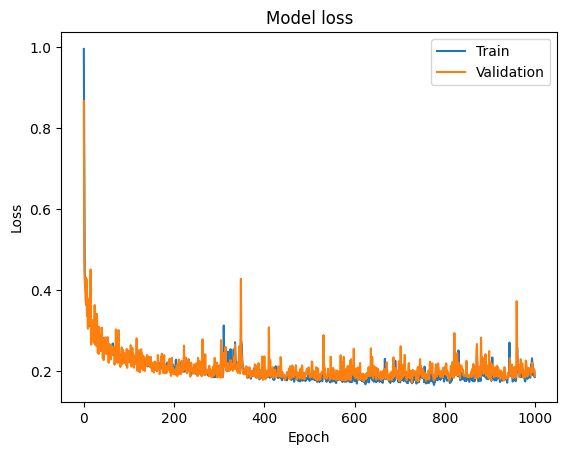

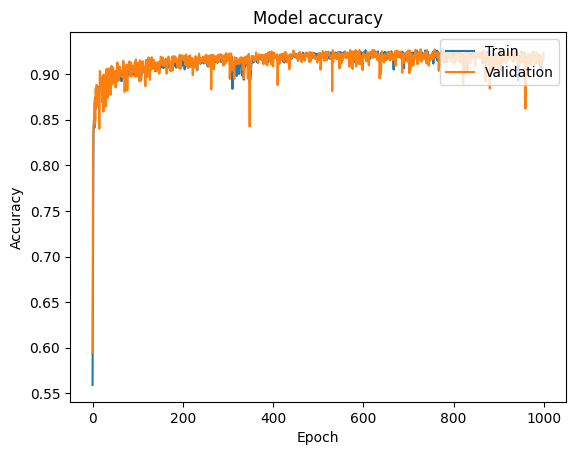

  6/108 [>.............................] - ETA: 1s - loss: 0.1825 - accuracy: 0.9180 

/home/yeojung/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['sequence_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


108/108 [==============================] - 1s 10ms/step - loss: 0.1861 - accuracy: 0.9222
Test Accuracy: 92.22
Test Loss: 18.61


In [ ]:
def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_test, phi_test, sequence_test)

In [ ]:
# 결과를 저장할 디렉토리 생성
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
# 모델 저장
model.save(os.path.join(models_dir, "NVspin_SimpleRNN_model_cuda.h5"))

# # 모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model = load_model("SimpleRNN_model.h5")

In [ ]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples.ravel(),
    'Phi': phi_samples.ravel(),
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 저장할 디렉토리 생성
results_dir = 'sample_simpleRNN'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 결과를 CSV 파일로 저장
df_results.to_csv(os.path.join(results_dir, 'simpleRNN_results.csv'), index=False)

print("Results saved to simpleRNN_results.csv")


1/1 [==============================] - 0s 101ms/step
Results saved to simpleRNN_results.csv


In [ ]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 19ms/step
Sample 1:
Theta    : [0.25019659]
Phi      : [4.22272085]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
----------
Sample 2:
Theta    : [0.14008434]
Phi      : [1.00165046]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------
Sample 3:
Theta    : [2.91582152]
Phi      : [1.7600918]
Actual   : [0 0 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 4 4]
Predicted: [0 0 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 4 1]
----------
Sample 4:
Theta    : [0.08155872]
Phi      : [3.73591258]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------
Sample 5: